In [1]:
import os
import pyspark 
from pyspark.sql import SparkSession
import seaborn as sb
import matplotlib.pyplot as plt
from pyspark.sql.functions import col



In [2]:
from dotenv import load_dotenv
load_dotenv()
key_filepath = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
os.environ['PYSPARK_PYTHON'] = os.getenv("PYSPARK_PYTHON")


In [3]:
spark = SparkSession.builder \
    .master("local[6]") \
    .appName("Airbnb Listings") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.google.cloud.auth.service.account.json.keyfile",key_filepath  ) \
    .config("spark.hadoop.google.cloud.auth.service.account.enable", "true") \
    .getOrCreate()       


    

In [4]:

# Read data from GCS
df = spark.read.parquet("gs://airbnb-listings-421017-bucket/airbnb_listings.parquet")


#### Analyzing the listings based on room types


C:\Users\Mohamed Hussein\AppData\Local\Temp\ipykernel_29484\1653355992.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x = "room_type",y="count" ,  data = room_type_counts, palette="Set1")


<Axes: xlabel='room_type', ylabel='count'>

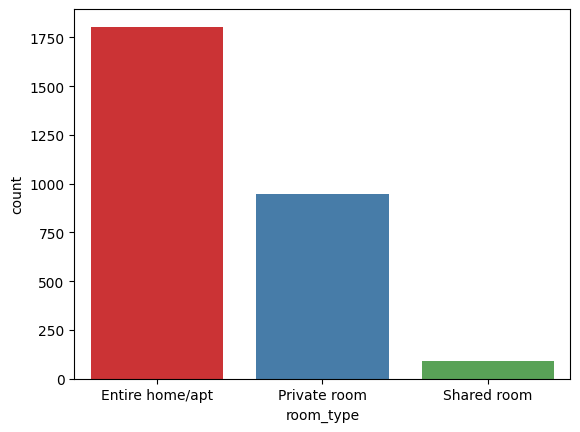

In [5]:
from pyspark.sql.functions import col

# get the number of listings per room type descending

room_type_counts =df.groupBy("room_type").count().orderBy(col("count").desc()).toPandas()
sb.barplot(x = "room_type",y="count" ,  data = room_type_counts, palette="Set1")



#### Analyzing the listings based on the property type.


C:\Users\Mohamed Hussein\AppData\Local\Temp\ipykernel_29484\2115851842.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x = "property_type",y="count" ,  data = property_type_counts, palette="Set1")


<Axes: xlabel='property_type', ylabel='count'>

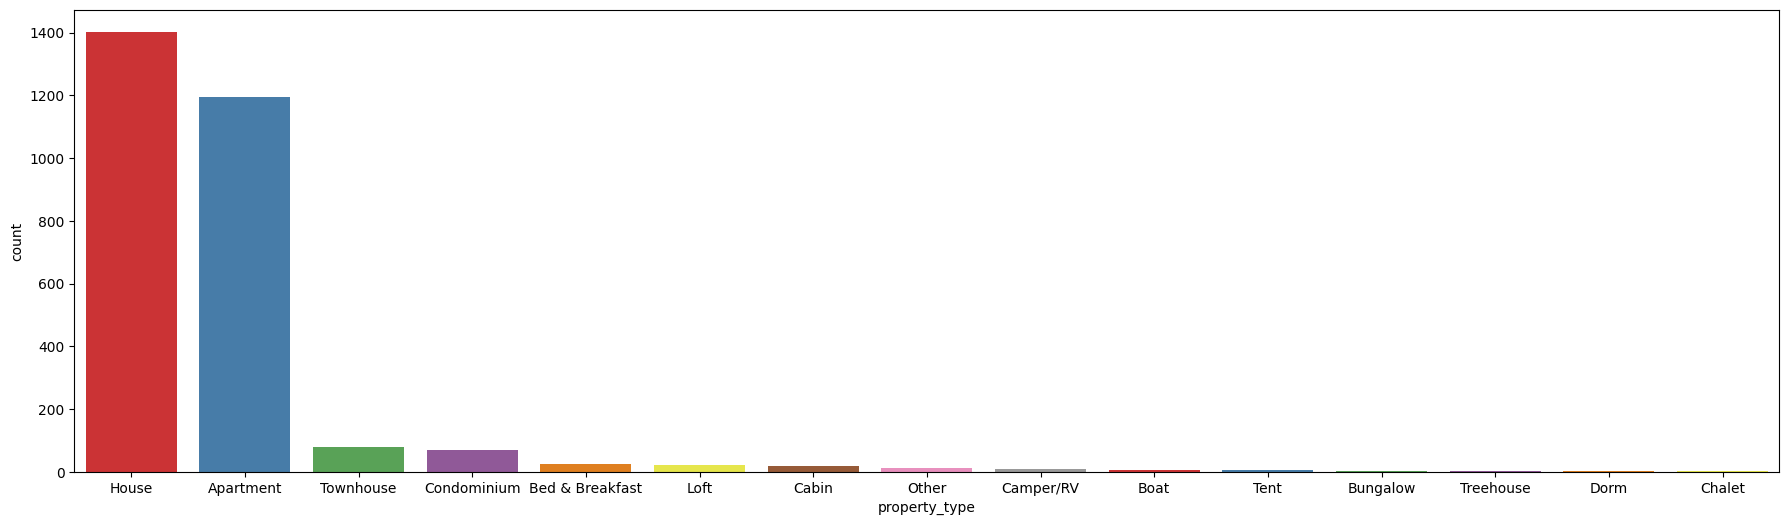

In [6]:

property_type_counts = df.groupBy("property_type").count().orderBy(col("count").desc()).toPandas()
plt.figure(figsize=(22, 6))  # Adjust the width and height as needed
sb.barplot(x = "property_type",y="count" ,  data = property_type_counts, palette="Set1")

#### Analyzing the prices for the different room and property types.


In [7]:
# get the price group by room_type and property_type
price_group = df.groupBy("room_type","property_type").agg({"price":"avg"}).toPandas()

<Axes: xlabel='room_type', ylabel='property_type'>

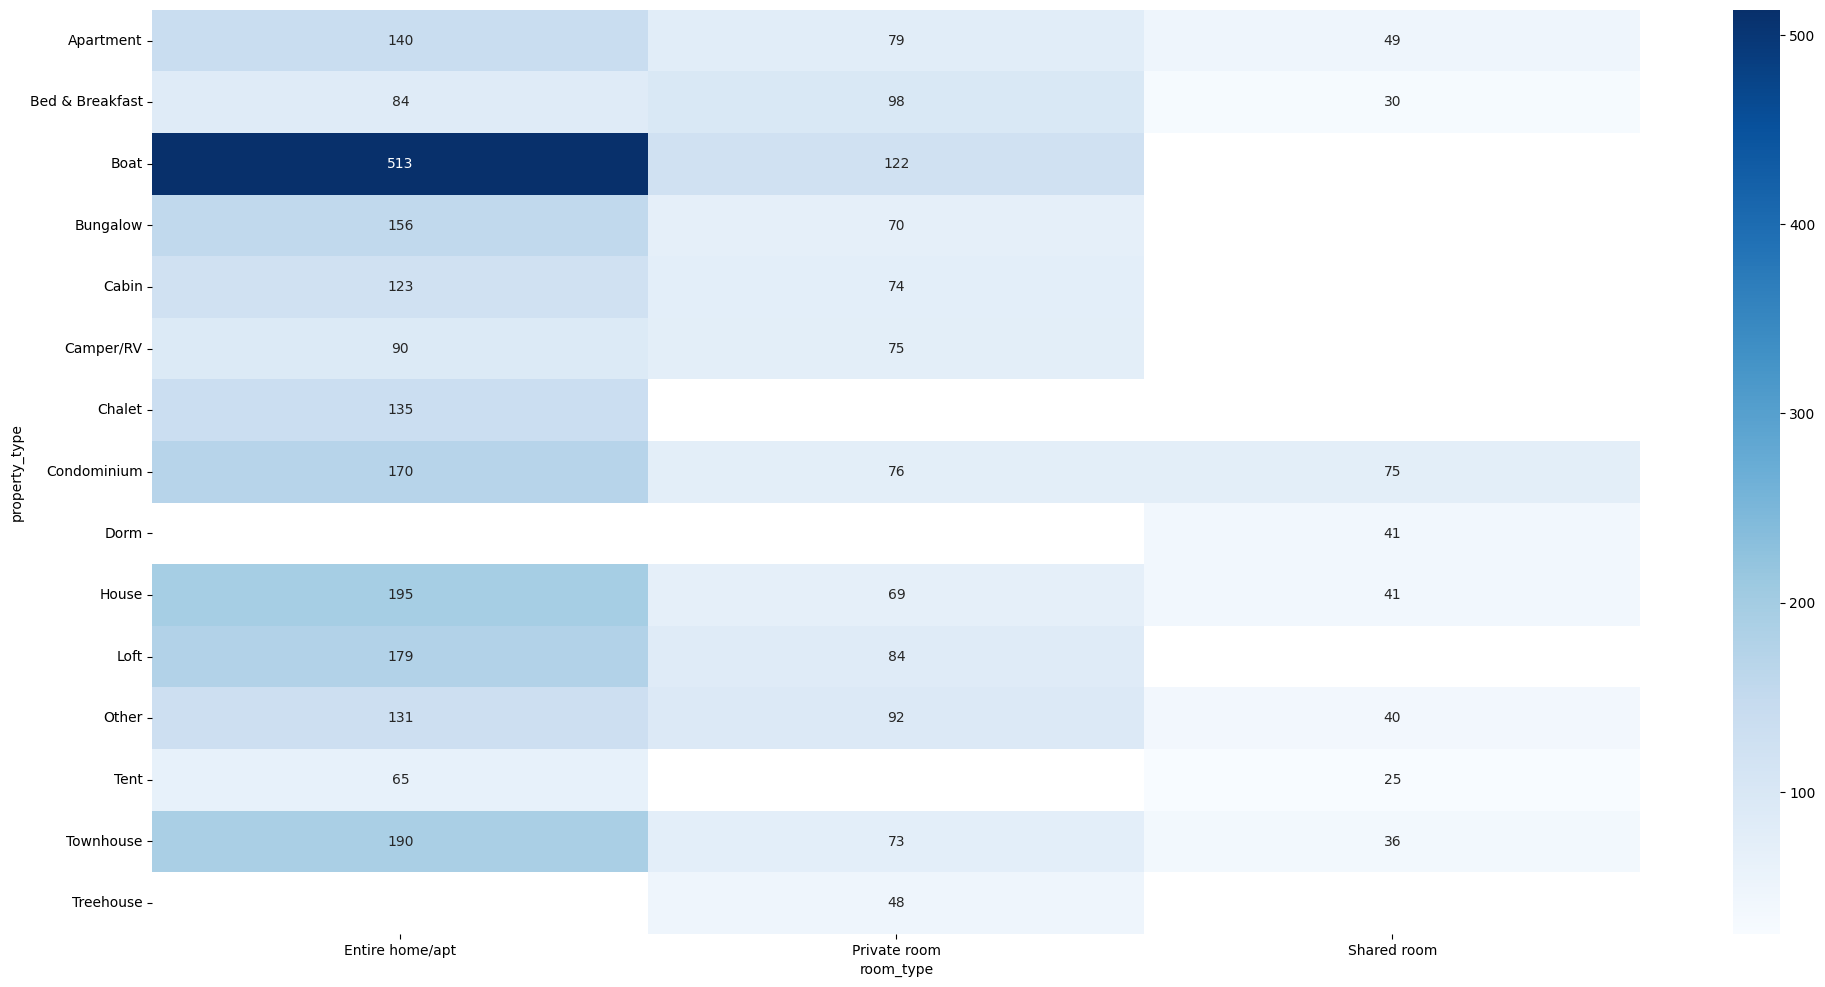

In [8]:
price_heatmap = price_group.pivot(index="property_type", columns="room_type", values="avg(price)")
# print(price_heatmap)
plt.figure(figsize=(24, 12))  # Adjust the width and height as needed
sb.heatmap(price_heatmap, cmap="Blues", annot=True, fmt=".0f")


#### Anaylzing the listings based on the number of bedrooms.


In [9]:

beds_count = df.select('price','bedrooms').toPandas()

C:\Users\Mohamed Hussein\AppData\Local\Temp\ipykernel_29484\4143978759.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(x='bedrooms', y='price', data=beds_count , palette="Set1")


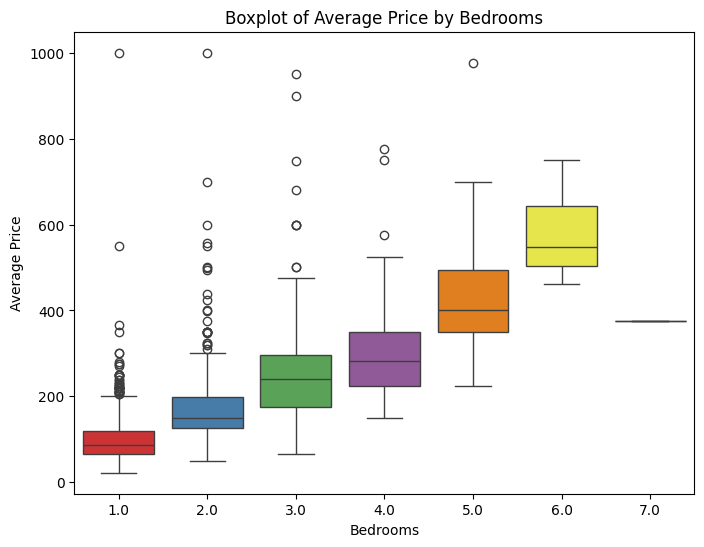

In [10]:
# Create boxplot
plt.figure(figsize=(8, 6))
sb.boxplot(x='bedrooms', y='price', data=beds_count , palette="Set1")
plt.title('Boxplot of Average Price by Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Average Price')
plt.show()

#### Analyzing if any particular ammenity results in higher prices.


In [11]:
# return the top 100 amenities by price

top_amenities =df.select('amenities').sort(col("price").desc()).limit(100)

In [12]:
from pyspark.sql.functions import split, explode, regexp_extract, regexp_replace

regex_pattern = r'[a-zA-Z]+' # extract only the words
# remove the special characters
top_amenities = top_amenities.withColumn("amenities", regexp_replace(col("amenities"), '[{}"\\s]+', ' '))

top_amenities = top_amenities.withColumn('amenities', explode(split(top_amenities['amenities'], ',')))

# transform the data to lowercase and then return it as a list 



In [13]:

# flatten the column 
ammenities_list = top_amenities.select('amenities').rdd.flatMap(lambda x: x).collect() 

# apply trim and lower case to the data 

ammenities_list = [x.strip().lower() for x in ammenities_list]

ammenities_words = ' '.join(ammenities_list)

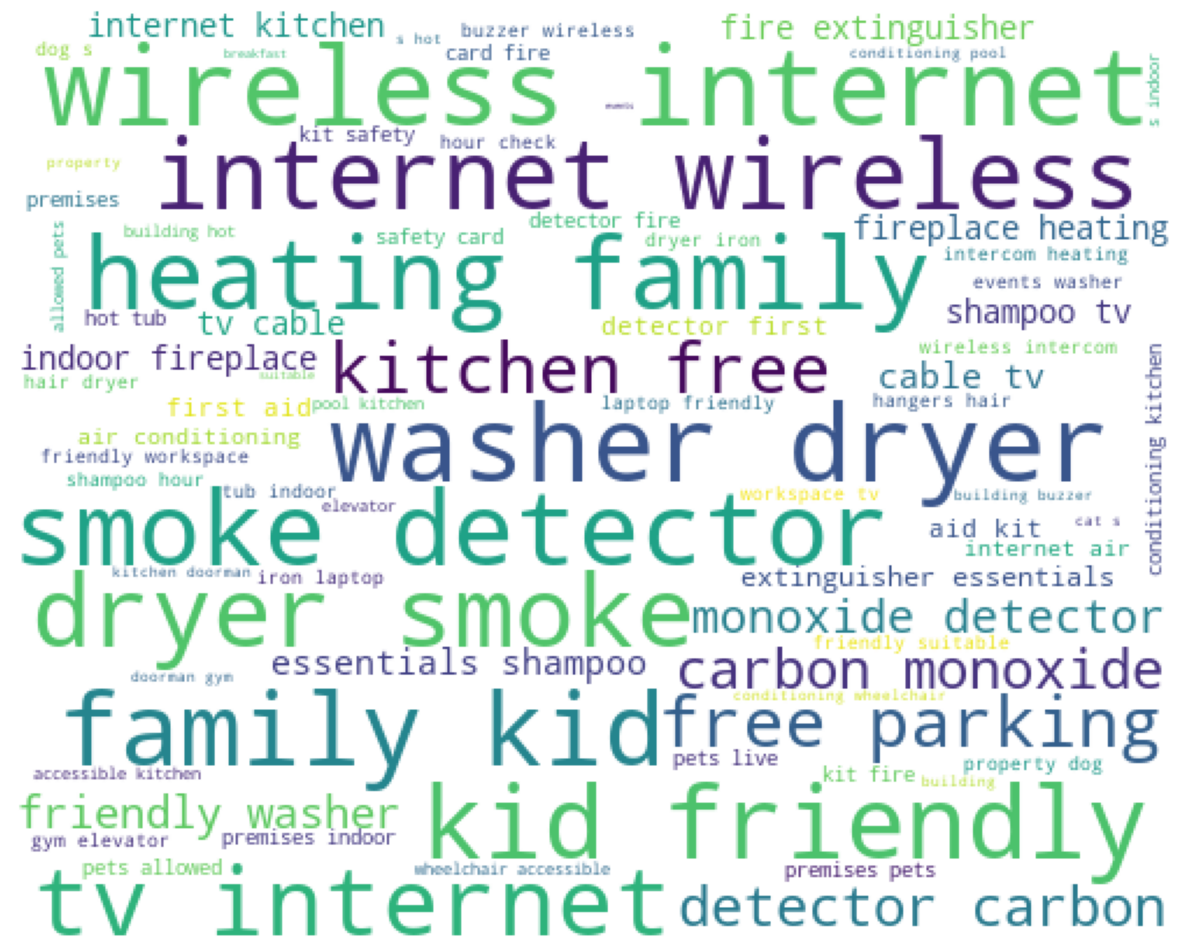

In [14]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(width = 500, height = 400, background_color="white").generate(ammenities_words)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()